# Pixel classification explained with SHAP
SHapley Additive exPlanations (SHAP) is a technique for visualizing how, for example random forest classifiers work. In this example we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) for pixel classification.

See also
* [Scikit-learn random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [SHAP documentation](https://shap.readthedocs.io/en/latest/)
* [Shapley value](https://en.wikipedia.org/wiki/Shapley_value)

In [1]:
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from skimage.io import imread, imsave
import numpy as np
import stackview
import matplotlib.pyplot as plt
import pandas as pd
from utilities import format_data, add_background, generate_feature_stack, visualize_image_list, apply_threshold_range, get_plt_figure

As example image, use a cropped and modified image from [BBBC038v1](https://bbbc.broadinstitute.org/bbbc/BBBC038), available from the Broad Bioimage Benchmark Collection [Caicedo et al., Nature Methods, 2019](https://doi.org/10.1038/s41592-019-0612-7).

[[ 5.          6.69491525  7.38983051 ... 43.61016949 44.30508475
  46.        ]
 [ 8.69491525  9.38983051 10.08474576 ... 44.30508475 46.
  45.69491525]
 [10.38983051 11.08474576 13.77966102 ... 45.         45.69491525
  46.38983051]
 ...
 [65.61016949 67.30508475 66.         ... 87.22033898 87.91525424
  88.61016949]
 [70.30508475 71.         72.69491525 ... 88.91525424 89.61016949
  90.30508475]
 [76.         76.69491525 77.38983051 ... 91.61016949 92.30508475
  92.        ]]
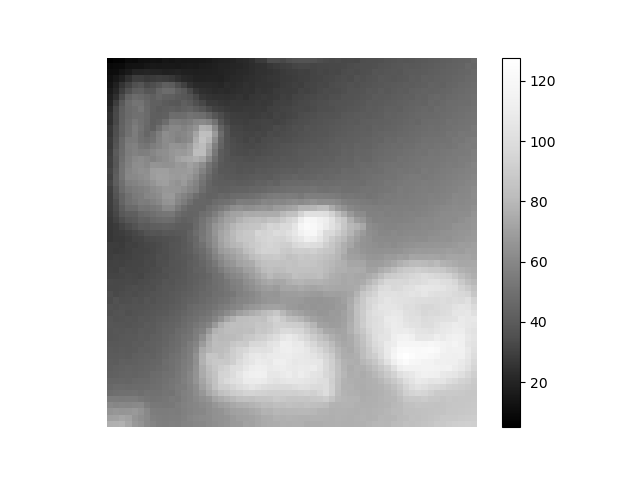
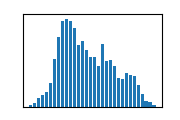

In [2]:
image = add_background(imread('data/0bf4b1.tif')[4:64,106:166])

stackview.insight(image)


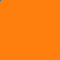

In [3]:
binary_masks = apply_threshold_range(image) + 1

# Visualize the animation 
stackview.animate(binary_masks, zoom_factor=5)

For demonstrating how the algorithm works, we annotate two small regions on the left of the image with values 1 and 2 for background and foreground (objects).

In [4]:
manual_annotation = False
if manual_annotation:
    annotation = np.zeros(image.shape, dtype=np.uint32)
    display(stackview.annotate(image, annotation, zoom_factor=4))

**Note:** If `manual_annotation` is true, you need to annotate pixels with your mouse above before executing the next cell.


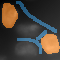

In [5]:
annotation_filename = "data/0bf4b1_annotation.tif"

if manual_annotation:
    imsave(annotation_filename, annotation)
else:
    annotation = imread(annotation_filename)
stackview.animate_curtain(image, annotation, alpha=0.6, zoom_factor=4)

## Generating a feature stack
Pixel classifiers such as the random forest classifier takes multiple images as input. We typically call these images a feature stack because for every pixel exist now multiple values (features). In the following example we create a feature stack containing three features:
* The original pixel value
* The pixel value after a Gaussian blur
* The pixel value of the Gaussian blurred image processed through a Sobel operator.

Thus, we denoise the image and detect edges. All three images serve the pixel classifier to differentiate positive and negative pixels.

In [6]:
feature_names = ["original", "top_hat(10)", "gaussian_sobel(1)", "random"]

feature_stack = generate_feature_stack(image, feature_names)
feature_stack.shape

(4, 60, 60)

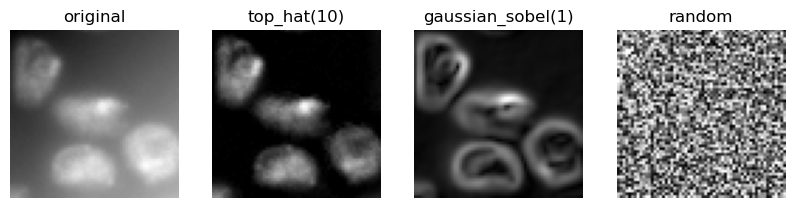

In [7]:
visualize_image_list(feature_stack, feature_names)

## Formatting data
We now need to format the input data so that it fits to what scikit learn expects. Scikit-learn asks for an array of shape (n, m) as input data and (n) annotations. n corresponds to number of pixels and m to number of features. In our case m = 3.

In [8]:
X, y = format_data(feature_stack, annotation)

print("input shape", X.shape)
print("annotation shape", y.shape)

input shape (969, 4)
annotation shape (969,)


## Training the random forest classifier
We now train the [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) by providing the feature stack X and the annotations y.

In [9]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

## Predicting pixel classes
After the classifier has been trained, we can use it to predict pixel classes for whole images. Note in the following code, we provide `feature_stack.T` which are more pixels then X in the commands above, because it also contains the pixels which were not annotated before.


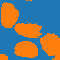

In [10]:
prediction = classifier.predict(np.asarray([f.ravel() for f in feature_stack]).T).reshape(image.shape)
stackview.animate_curtain(image, prediction, zoom_factor=4)

## SHAP
SHAP analysis allows us to visualize to what degree features contribute to decisions the classifier makes. 

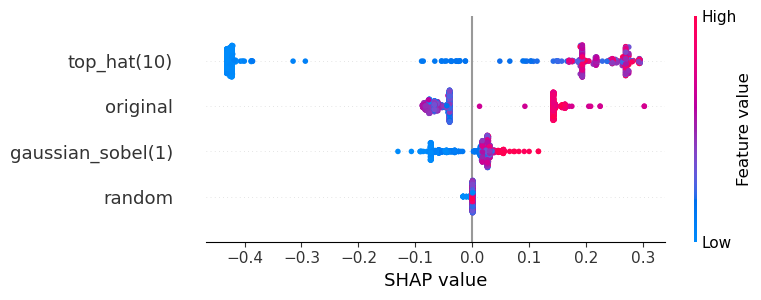

In [11]:
def visualize_shap(classifier, feature_names, target_class=-1):
    import shap
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(classifier)
    
    # Calculate SHAP values 
    shap_values = explainer.shap_values(X)[...,target_class]

    # Create a new figure with larger size for better visibility
    plt.figure(figsize=(40, 8))
    
    # Create SHAP summary plot with feature names
    shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
    
    # Style plot and show it 
    #plt.title('SHAP Feature Importance and Impact', pad=20)
    plt.xlabel("SHAP value")
    plt.tight_layout()

visualize_shap(classifier, feature_names)



The plot above can be read like:
* The top-hat filtered image is the most crucial for the segmentation of the objects. If top-hat filtered pixel values are high, the classifier sees the pixel as positive (red).
* The original and the Gaussian-blurred image contribute to the decision as well, but not as prominently because the SHAP values are closer to 0.
* The random image does not contribute to the classification.

To interpret the plot above more easily, we show the feature images again:

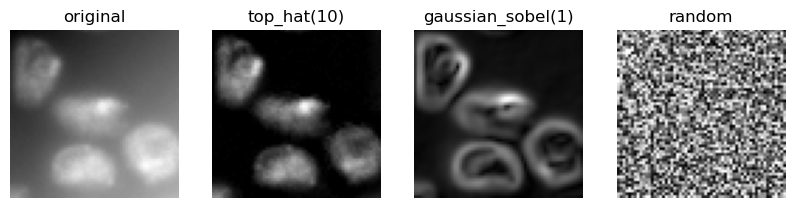

In [12]:
visualize_image_list(feature_stack, feature_names)

## Beware of correlation
We will execute the same procedure again, but this time with strongly correlating features.

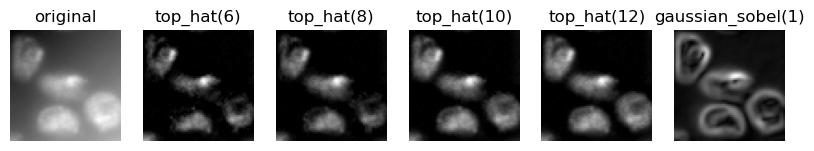

In [13]:
feature_names = ["original"] + [f"top_hat({r})" for r in range(6, 14, 2)] + ["gaussian_sobel(1)"]

feature_stack = generate_feature_stack(image, feature_names)
visualize_image_list(feature_stack, feature_names)

In [14]:
X, y = format_data(feature_stack, annotation)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)


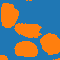

In [15]:
prediction = classifier.predict(np.asarray([f.ravel() for f in feature_stack]).T).reshape(image.shape)
stackview.animate_curtain(image, prediction, zoom_factor=4)

In this shap plot it _seems_ the Gaussian blurred image and the original are less useful compared to the SHAP plot above. However, the strongly correlating top-hat features might mislead our perception.

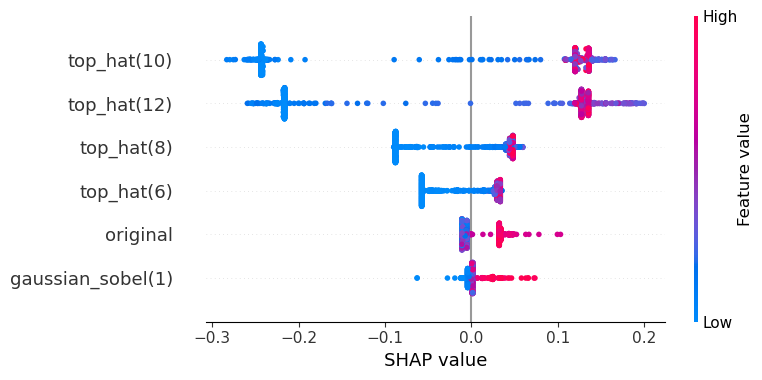

In [16]:
visualize_shap(classifier, feature_names)

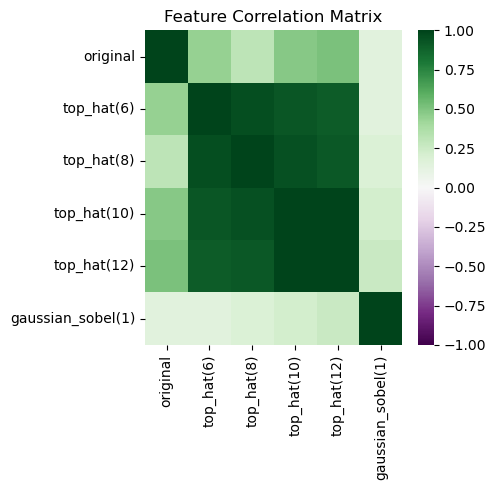

In [17]:
import seaborn as sns

# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)

# Calculate correlation matrix
correlation_matrix = df.corr()

# Create heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, 
            cmap='PRGn',  # Purple-Green diverging colormap
            center=0,     # Center the colormap at 0
            vmin=-1,      # Set minimum value
            vmax=1,       # Set maximum value
            annot=False,   # Show correlation values
            fmt='.2f')    # Format numbers to 2 decimal places
plt.title('Feature Correlation Matrix') 
plt.tight_layout()
plt.show()

The SHAP values are defined for all classes. In case of a binary classification, the two SHAP plots show oppsing values. Hence, showing one is enough. For completeness, here we see the two SHAP plots. The first is for predicing the class 0 (blue) and the second for class 1 (orange).

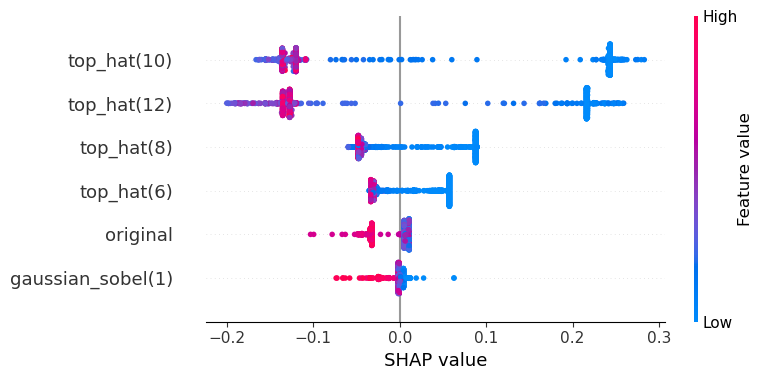

In [18]:
visualize_shap(classifier, feature_names, target_class=0)

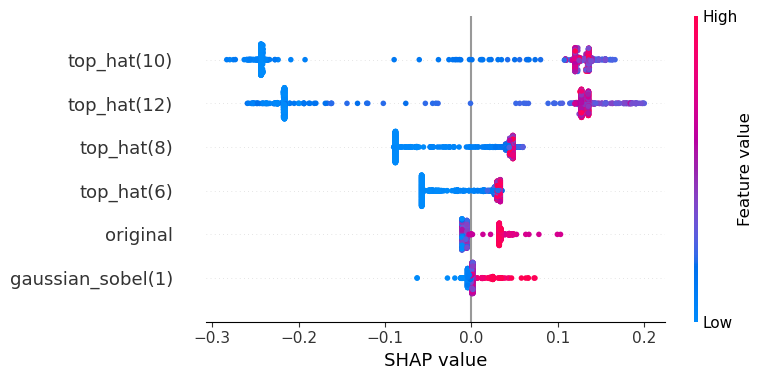

In [19]:
visualize_shap(classifier, feature_names, target_class=1)

## Exercise
Interpret the features in this SHAP plot.

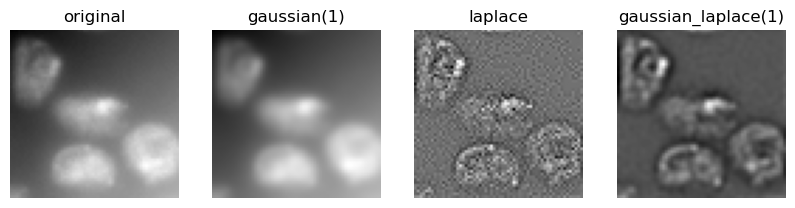

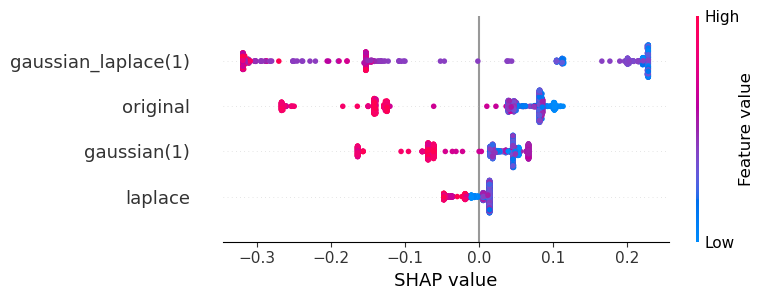

In [20]:
feature_names = ["original", "gaussian(1)", "laplace", "gaussian_laplace(1)"]

feature_stack = generate_feature_stack(image, feature_names)
visualize_image_list(feature_stack, feature_names)

X, y = format_data(feature_stack, annotation)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

visualize_shap(classifier, feature_names, target_class=0)

## Exercise
Execute the procedure demonstrated above to segment the edges of the objects in the image.